In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
holidays = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


<Axes: xlabel='date'>

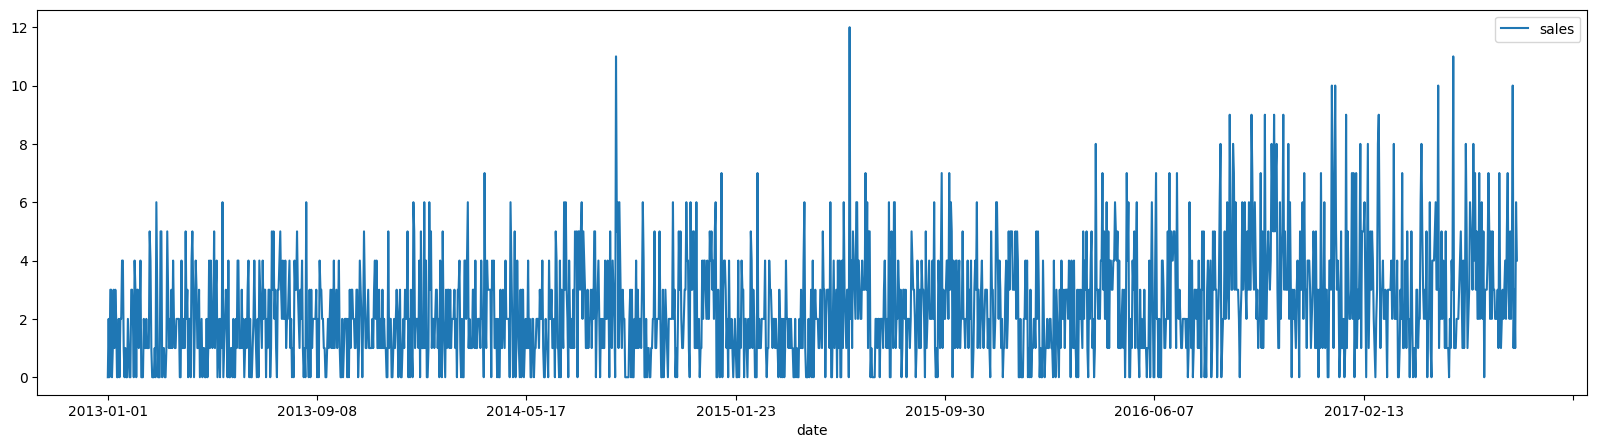

In [5]:
train[(train["store_nbr"] == 1) & (train["family"] == "BEAUTY")][["date", "sales"]].plot(x="date", y="sales", figsize=(20, 5))

In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
oil = oil.fillna(0)

In [8]:
train = pd.merge(train, oil, on="date", how="left")

In [9]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0


In [10]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores.type.value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [12]:
stores.cluster.value_counts()

cluster
3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: count, dtype: int64

In [13]:
stores = pd.get_dummies(stores, columns=["type", "cluster"], drop_first=True, dtype=int)
stores.head()

,store_nbr,city,state,type_B,type_C,type_D,type_E,cluster_2,cluster_3,cluster_4,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1,Quito,Pichincha,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,Quito,Pichincha,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,Quito,Pichincha,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Quito,Pichincha,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
stores = stores[["store_nbr", "type_B", "type_C", "type_D", "type_E", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8", "cluster_9",
                 "cluster_10", "cluster_11", "cluster_12", "cluster_13", "cluster_14", "cluster_15", "cluster_16", "cluster_17"]]

In [15]:
train = pd.merge(train, stores, on="store_nbr", how="left")
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_B,type_C,type_D,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [16]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [17]:
holidays = holidays[holidays["transferred"] == False]
holidays = holidays[holidays["locale"].isin(["National", "Regional"])]
holidays = holidays[["date", "description"]]
holidays = pd.get_dummies(holidays, columns=["description"], prefix="", prefix_sep="", dtype=int)

In [18]:
train = pd.merge(train, holidays, on="date", how="left")

In [19]:
train = train.drop("id", axis=1)

In [20]:
train["date"] = pd.to_datetime(train["date"])

In [21]:
train = train.set_index(["date"])

In [22]:
train.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,type_B,type_C,type_D,type_E,cluster_2,...,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+8,Terremoto Manabi+9,Traslado Batalla de Pichincha,Traslado Independencia de Guayaquil,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,0.0,0,0.0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
average_sales = (
    train["sales"]
    .groupby('date').mean()
    .squeeze()
)

<Axes: xlabel='day'>

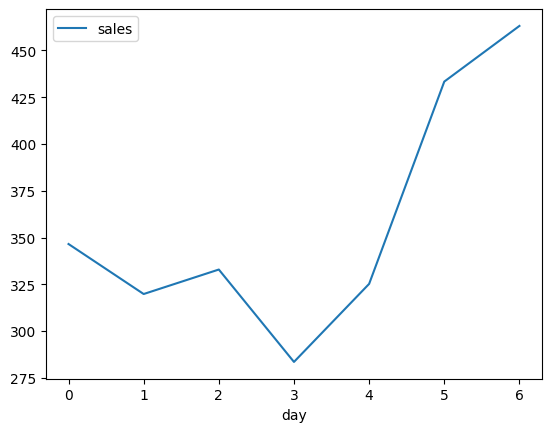

In [24]:
# Plot seasonal sales inside a week
average_sales = average_sales.to_frame()
average_sales["day"] = average_sales.index.dayofweek
average_sales_weekday = average_sales.groupby("day").mean()
average_sales_weekday.plot()

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

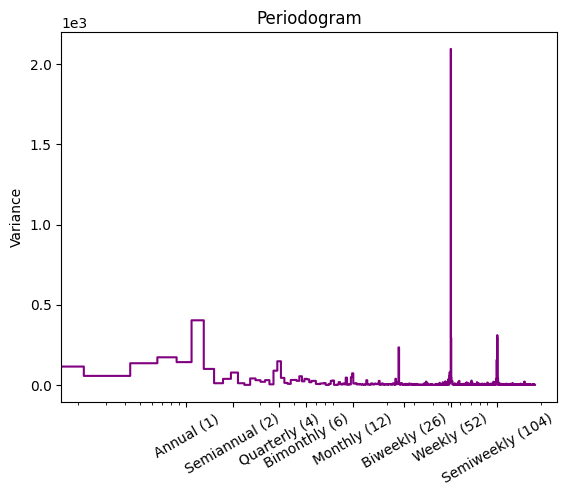

In [26]:
plot_periodogram(average_sales["sales"])

In [31]:
y = train[["store_nbr", "family", "sales"]].copy()
y = y.reset_index()
y


,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3009793,2017-08-15,9,POULTRY,438.133
3009794,2017-08-15,9,PREPARED FOODS,154.553
3009795,2017-08-15,9,PRODUCE,2419.729
3009796,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000


In [32]:
y["store_nbr"] = y["store_nbr"].astype("category")
y["family"] = y["family"].astype("category")
y["date"] = y["date"].dt.to_period("D")
#y = y.set_index(['store_nbr', 'family', 'date']).sort_index()
y

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3009793,2017-08-15,9,POULTRY,438.133
3009794,2017-08-15,9,PREPARED FOODS,154.553
3009795,2017-08-15,9,PRODUCE,2419.729
3009796,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000


In [34]:
y = y.pivot_table(index="date", columns=["store_nbr", "family"], values="sales", fill_value=0)

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_1988\829371325.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  y = y.pivot_table(index="date", columns=["store_nbr", "family"], values="sales", fill_value=0)


In [35]:
y

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                        ...        54             \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES      MEATS   
date                                             ...                        
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771000   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257000   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223000   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431000   
...                ...      ...    ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       0.0  50.756000   
2017-08-12         3.0    351.0  526.0   99.488  ...       1.0  53.079002   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  67.435000   
2017-08-14         4.0    571.0  699.0  154.578  ...       1.0  64.224000   
2017-08-15        21.0    703.0  602.0  116.402  ...       2.0  57.842000   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-01           0.0          0.0                     0.0   0.000000   
2013-01-02         228.0          0.0                     0.0  15.514000   
2013-01-03         156.0          0.0                     0.0   4.313000   
2013-01-04         146.0          0.0                     0.0  26.743000   
2013-01-05         205.0          0.0                     0.0  31.118000   
...                  ...          ...                     ...        ...   
2017-08-11         155.0          0.0                     0.0  80.759000   
2017-08-12         169.0          0.0                     4.0  91.671000   
2017-08-13         244.0          0.0                     2.0  79.062996   
2017-08-14         200.0          0.0                     1.0  56.155000   
2017-08-15         169.0          0.0                     2.0  59.619000   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2013-01-01            0.0    0.000                        0.0     0.0  
2013-01-02           61.0    0.000                        0.0     3.0  
2013-01-03            1.0    0.000                        0.0     2.0  
2013-01-04           38.0    0.000                        0.0     2.0  
2013-01-05           32.0    0.000                        0.0     1.0  
...                   ...      ...                        ...     ...  
2017-08-11           54.0  546.250                        0.0     0.0  
2017-08-12           81.0  696.920                        0.0     1.0  
2017-08-13           91.0  877.304                        0.0     2.0

In [65]:
oil["date"] = pd.to_datetime(oil["date"]).dt.to_period("D")

In [76]:
fourier = CalendarFourier(freq="ME", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X["holiday"] = y.index.isin(holidays.index)
X = X.merge(oil, left_index=True, right_on="date", how="left")
X = X.set_index(y.index).drop("date", axis=1)
X = X.fillna(0)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [77]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",NewYear,holiday,dcoilwtico
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True,False,0.00
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False,False,93.14
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False,False,92.97
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False,False,93.12
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False,False,48.81
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False,False,0.00
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False,False,0.00


In [78]:
y_pred

store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2013-01-01  -1.393507       0.0 -0.896865  -756.296952 -0.284730   -82.797546   
2013-01-02   2.412411       0.0  1.880299   883.030831 -0.158067   296.869247   
2013-01-03   2.118333       0.0  1.898238   815.938851 -0.218325   267.380857   
2013-01-04   2.502464       0.0  2.001304   921.284554 -0.095101   279.093204   
2013-01-05   1.558463       0.0  1.272062   563.120347 -0.243373   197.744528   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   4.989451       0.0  3.288842  2495.306821  0.436895   450.847498   
2017-08-12   4.378074       0.0  2.936923  2386.980784  0.395022   396.573424   
2017-08-13   4.413973       0.0  2.831567  2258.704882  0.435097   382.196547   
2017-08-14   4.464125       0.0  3.307982  2386.116429  0.460578   409.961319   
2017-08-15   4.779969       0.0  3.555227  2510.301132  0.580226   423.481502   

store_nbr                                                   ...        54  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2013-01-01   -9.091472 -100.042249 -183.279339  -21.728506  ... -0.555258   
2013-01-02   -1.009585  728.916769  469.728426  117.722955  ... -0.157271   
2013-01-03   -1.870647  667.751347  433.441808  108.234827  ... -0.228294   
2013-01-04   -0.325139  714.933329  462.310906  110.927106  ... -0.466968   
2013-01-05   -3.897430  451.460432  341.772223   83.796328  ... -0.355260   
...                ...         ...         ...         ...  ...       ...   
2017-08-11   20.609864  766.879001  866.811645  151.207255  ...  1.137082   
2017-08-12   18.423770  610.959976  805.450059  134.435477  ...  1.415961   
2017-08-13   16.263058  590.789850  752.218085  130.131040  ...  1.415302   
2017-08-14   16.509248  683.955348  799.541909  140.981736  ...  1.195006   
2017-08-15   17.260047  736.583663  836.306816  146.928353  ...  0.990901   

store_nbr                                                                 \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2013-01-01  -2.188414    -11.013158    -0.125559               -1.995819   
2013-01-02  43.653605    158.474225    -0.031937               -0.120788   
2013-01-03  46.513924    172.580601     0.012064               -0.231568   
2013-01-04  42.040238    160.645676    -0.042023               -0.338495   
2013-01-05  61.031903    242.110562     0.045791               -0.031803   
...               ...           ...          ...                     ...   
2017-08-11  53.792649    165.295973     0.224675                3.966033   
2017-08-12  57.849007    217.995687     0.193671                4.731375   
2017-08-13  59.856684    230.428296     0.238200                4.933880   
2017-08-14  55.724150    194.954546     0.273520                4.371008   
2017-08-15  53.734509    198.014491     0.195224                4.186004   

store_nbr                                                                    \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2013-01-01  -5.755717     -16.310303 -357.893810                  -1.136624   
2013-01-02  38.236237      38.799262  -43.127521                  -0.195470   
2013-01-03  40.120384      41.469384  -37.093638                  -0.470789   
2013-01-04  33.338776      37.497660  -34.221935                  -0.915048   
2013-01-05  49.457734      47.215824   17.913309                  -0.780739   
...               ...            ...         ...                        ...   
2017-08-11

In [48]:
y.loc(axis=1)[(1, "AUTOMOTIVE")]

date
2013-01-01    0.0
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
             ... 
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0
Freq: D, Name: (1, AUTOMOTIVE), Length: 1684, dtype: float64

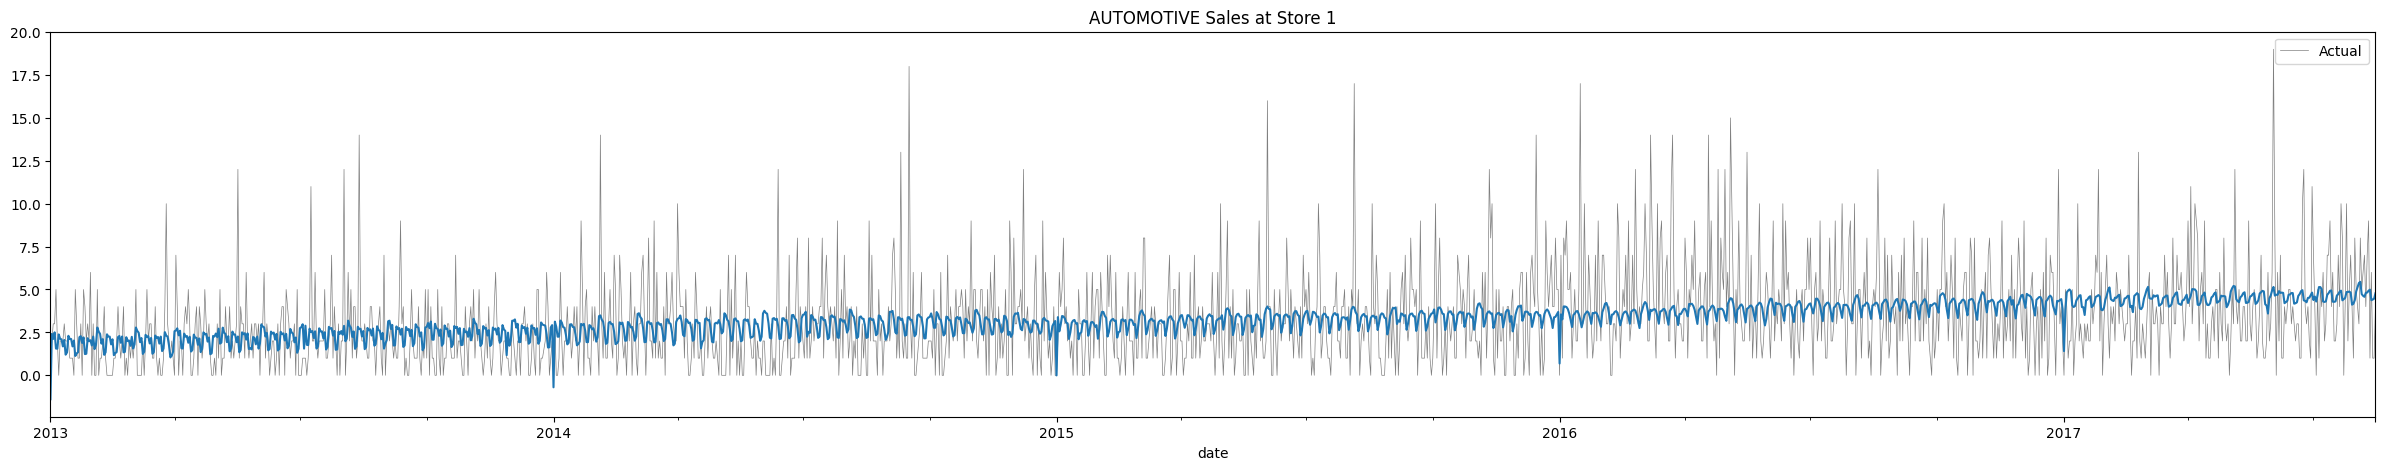

In [79]:
STORE_NBR = 1  # 1 - 54
FAMILY = 'AUTOMOTIVE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[(STORE_NBR, FAMILY)].plot(figsize=(30, 5), title=f'{FAMILY} Sales at Store {STORE_NBR}', legend=True, label='Actual', color='black', alpha=0.5, linewidth=0.5)
ax = y_pred.loc(axis=1)[(STORE_NBR, FAMILY)].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [80]:
y_pred = y_pred.applymap(lambda x: 0 if x < 0 else x)

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_1988\3455201706.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_pred = y_pred.applymap(lambda x: 0 if x < 0 else x)


In [81]:
root_mean_squared_log_error(y.loc(axis=1)[(STORE_NBR, FAMILY)], y_pred.loc(axis=1)[(STORE_NBR, FAMILY)])

0.6613439203537523

In [82]:
root_mean_squared_log_error(y, y_pred)

0.8636938404958088